In [1]:
import sys
import os

# Get the current working directory of the notebook
notebook_dir = os.getcwd()

# Add the parent directory to sys.path
parent_dir = os.path.abspath(os.path.join(notebook_dir, '..'))
if parent_dir not in sys.path:
    sys.path.append(parent_dir)

# AutoCorrelation Block

Training model with TimesBlock input processor...


Training:  51%|█████     | 51/100 [00:04<00:03, 13.15epoch/s]

Epoch 50: Train Loss = 0.2961


Training: 100%|██████████| 100/100 [00:07<00:00, 12.95epoch/s]


Epoch 100: Train Loss = 0.1085

Validation Forecast Error Metrics:
  MSE   = 0.615691
  RMSE  = 0.784660
  MAE   = 0.628713
Validation metrics: {'mse': 0.6156914, 'rmse': 0.78466004, 'mae': 0.62871295}


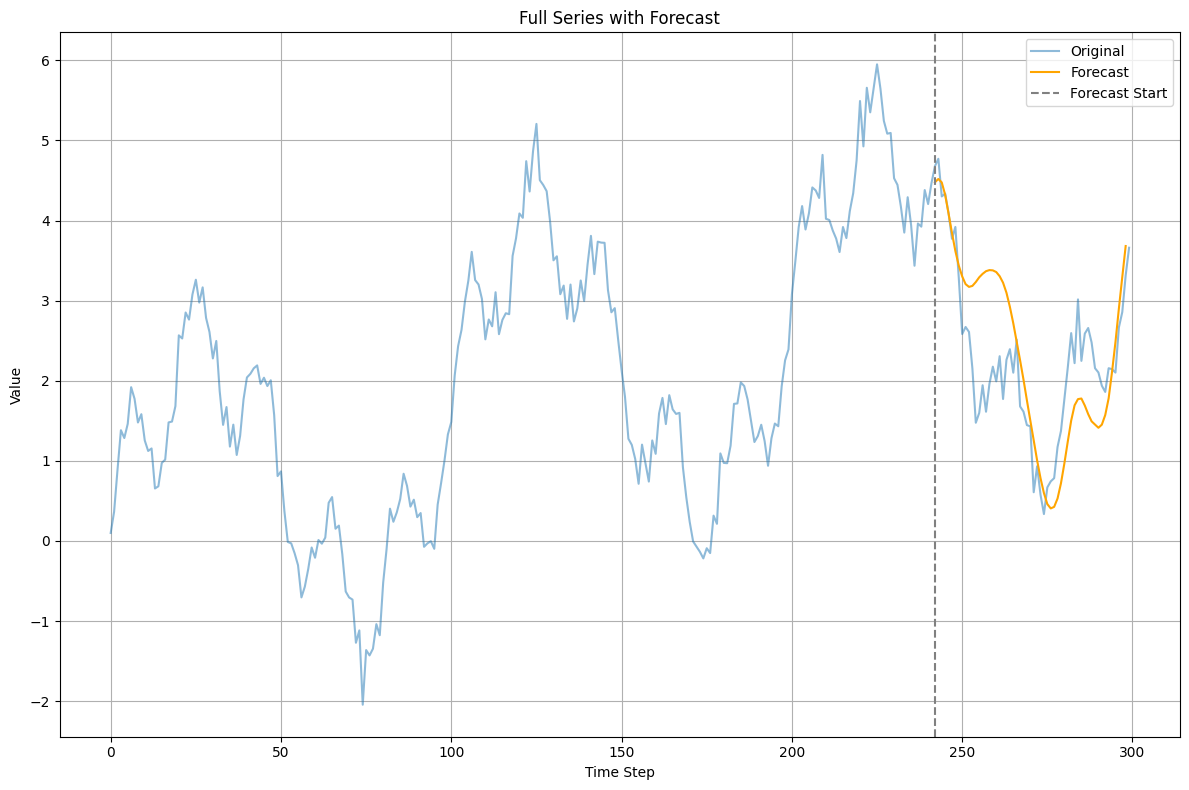


Training baseline model without TimesBlock...


Training:  56%|█████▌    | 56/100 [00:01<00:01, 31.77epoch/s]

Epoch 50: Train Loss = 0.3108


Training: 100%|██████████| 100/100 [00:03<00:00, 32.12epoch/s]

Epoch 100: Train Loss = 0.0983

Validation Forecast Error Metrics:
  MSE   = 0.747080
  RMSE  = 0.864338
  MAE   = 0.683025
Baseline validation metrics: {'mse': 0.74707955, 'rmse': 0.8643376, 'mae': 0.68302524}


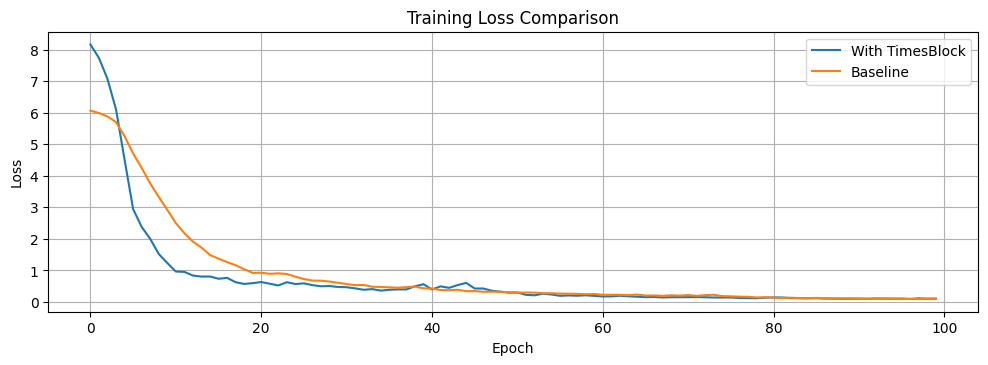

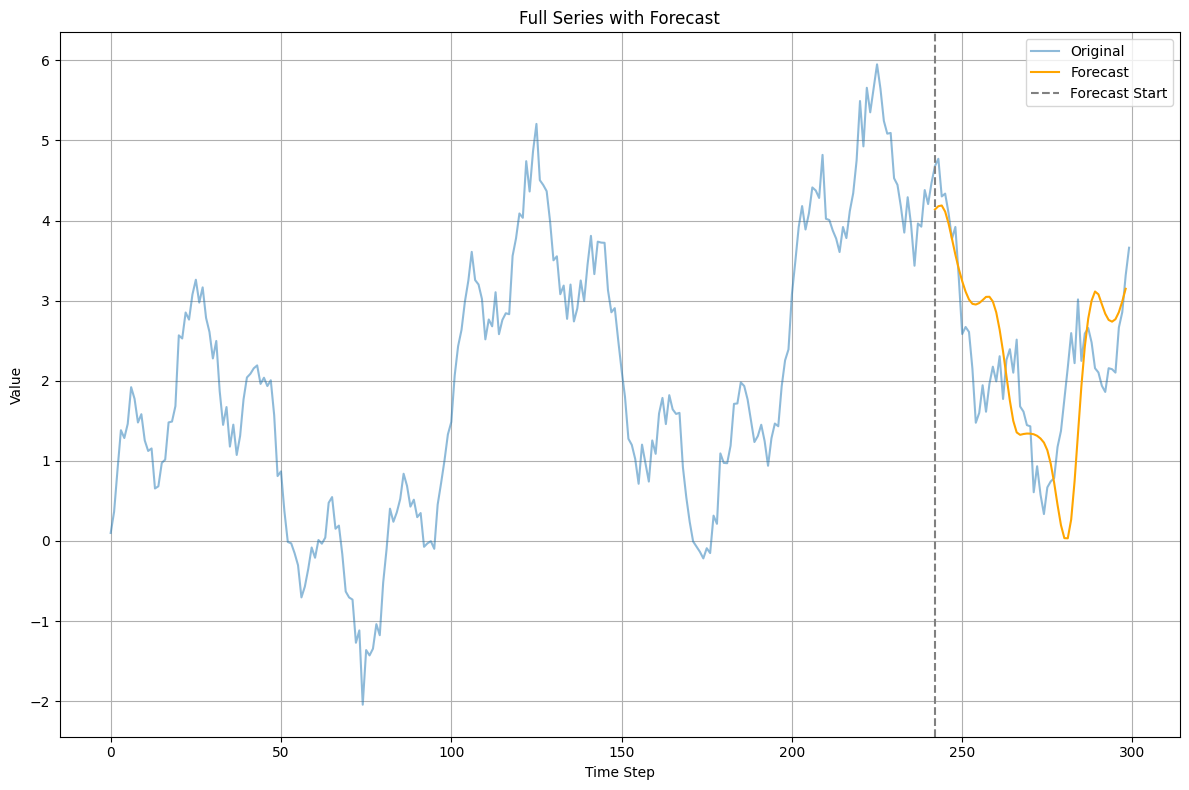

TimesBlock enhanced model performance metrics:
With TimesBlock: {'mse': 0.6156914, 'rmse': 0.78466004, 'mae': 0.62871295}
Baseline: {'mse': 0.74707955, 'rmse': 0.8643376, 'mae': 0.68302524}
Improvement in MSE: 17.59%


In [ ]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
from foreblocks import ForecastingModel
from foreblocks import LSTMDecoder, LSTMEncoder
from foreblocks import Trainer
from foreblocks.att import AttentionLayer
from foreblocks.blocks.attention import AutoCorrelationPreprocessor

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Parameters
input_size = 1
hidden_size = 64
embedding_size = 64
num_layers = 1
output_size = 1
target_len = 10
seq_len = 50
total_len = 300  # Total synthetic time series length

# Instantiate the AutoCorrelation preprocessor
times_wrapper = AutoCorrelationPreprocessor(d_model=input_size, factor=2)

# 2. Create encoder and decoder
encoder = LSTMEncoder(
    input_size=input_size,  # AutoCorrelation retains input shape
    hidden_size=hidden_size,
    num_layers=num_layers
)

decoder = LSTMDecoder(
    input_size=output_size,
    hidden_size=hidden_size,
    output_size=output_size,
    num_layers=num_layers
)

# Optional attention module
attention_module = AttentionLayer(
    method='dot',
    attention_backend='xformers',
    encoder_hidden_size=hidden_size,
    decoder_hidden_size=hidden_size,
)

# 3. Create the model with AutoCorrelation as input_preprocessor
model = ForecastingModel(
    encoder=encoder,
    decoder=decoder,
    target_len=target_len,
    forecasting_strategy="seq2seq",
    teacher_forcing_ratio=0.5,
    output_size=output_size,
    input_skip_connection=True,
    input_preprocessor=times_wrapper,
    #attention_module=attention_module,
)

# 4. Set up trainer
trainer = Trainer(
    model,
    optimizer=torch.optim.Adam(model.parameters(), lr=0.001),
    criterion=nn.MSELoss()
)

# 5. Generate synthetic time series
t = np.linspace(0, 6 * np.pi, total_len)
time_series = (
    0.2 * t + 
    2.0 * np.sin(t) + 
    0.8 * np.sin(5 * t) + 
    0.4 * np.sin(0.2 * t) + 
    0.2 * np.random.randn(total_len)
)
time_series = torch.tensor(time_series, dtype=torch.float32).unsqueeze(-1)  # [T, 1]

# 6. Sliding windows
def create_sliding_windows(series, input_len, output_len):
    X, Y = [], []
    for i in range(len(series) - input_len - output_len):
        X.append(series[i:i+input_len])
        Y.append(series[i+input_len:i+input_len+output_len])
    return torch.stack(X), torch.stack(Y)

X, Y = create_sliding_windows(time_series, seq_len, target_len)
train_size = int(0.8 * len(X))
X_train, Y_train = X[:train_size], Y[:train_size]
X_val, Y_val = X[train_size:], Y[train_size:]

# 7. DataLoader
from torch.utils.data import DataLoader, TensorDataset
train_dataset = TensorDataset(X_train, Y_train)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# 8. Train the model
print("Training model with AutoCorrelation input processor...")
history = trainer.train(train_loader, epochs=100)

# 9. Evaluate
metrics = trainer.metrics(X_val, Y_val)
print(f"Validation metrics: {metrics}")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
with torch.no_grad():
    X_val = X_val.to(device)
    predictions = model(X_val)

# Plot prediction
trainer.plot_prediction(X_val, Y_val, full_series=time_series, offset=train_size)
plt.show()

# 10. Baseline model without any preprocessing
print("\nTraining baseline model without AutoCorrelation...")

encoder_baseline = LSTMEncoder(input_size, hidden_size, num_layers)
decoder_baseline = LSTMDecoder(output_size, hidden_size, output_size, num_layers)

model_baseline = ForecastingModel(
    encoder=encoder_baseline,
    decoder=decoder_baseline,
    target_len=target_len,
    forecasting_strategy="seq2seq",
    teacher_forcing_ratio=0.5,
    output_size=output_size,
)

trainer_baseline = Trainer(
    model_baseline,
    optimizer=torch.optim.Adam(model_baseline.parameters(), lr=0.001),
    criterion=nn.MSELoss()
)

history_baseline = trainer_baseline.train(train_loader, epochs=100)
metrics_baseline = trainer_baseline.metrics(X_val, Y_val)
print(f"Baseline validation metrics: {metrics_baseline}")

with torch.no_grad():
    predictions_baseline = model_baseline(X_val)

# Compare training losses
plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
plt.plot(history['train_losses'], label='With AutoCorrelation')
plt.plot(history_baseline['train_losses'], label='Baseline')
plt.title('Training Loss Comparison')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.show()

# Plot prediction for baseline
trainer_baseline.plot_prediction(X_val, Y_val, full_series=time_series, offset=train_size)
plt.show()

# Improvement analysis
print("AutoCorrelation enhanced model performance metrics:")
print(f"With AutoCorrelation: {metrics}")
print(f"Baseline: {metrics_baseline}")
improvement = (metrics_baseline['mse'] - metrics['mse']) / metrics_baseline['mse'] * 100
print(f"Improvement in MSE: {improvement:.2f}%")
